# 2022 NBA Champion Prediction

In [1]:
import os
import time
from decimal import ROUND_HALF_UP, Decimal
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from numpy import ndarray
from pandas import Series
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sqlalchemy import MetaData, and_, create_engine, select
from sqlalchemy.orm import DeclarativeBase, Session, aliased

### Plot Style

In [2]:
sns.set_style("darkgrid")

### Notebook Constants

In [3]:
# Directories.
PROJECT_DIR = Path.cwd().parents[1]
IMAGES_DIR = PROJECT_DIR / "src" / "static" / "images" / "machine_learning"
DATA_DIR = PROJECT_DIR / "src" / "data"

# Season to predict the champion for.
SEASON_CURRENT = 2022

# Seasons for the machine learning (ml) model.
SEASON_ML_START = 2016
SEASON_ML_END = SEASON_CURRENT - 1

# Colormap.
CMAP = sns.diverging_palette(150, 150, s=80, l=55, as_cmap=True)

# Image resolution.
IMAGE_DPI = 240.0

### Helper Function: Conventinal Rounding

In [4]:
def round_half_up(n, decimals=0):
    """Round `n` using a conventional round half up approach."""
    multiplier = Decimal("10") ** (-decimals)
    # `n` is converted to a string to ensure accurate representation of floats.
    result = Decimal(str(n)).quantize(multiplier, rounding=ROUND_HALF_UP)
    return float(result)

## Retrieve Stats
### Setup Database Connection and ORM Mapped Classes
#### Construct Database URI

In [5]:
# Load database credentials as environment variables from .env file.
load_dotenv(dotenv_path=PROJECT_DIR / "src" / ".env")

# Host, port, and database values.
db = os.environ.get("PGDATABASE")
host = os.environ.get("PGHOST")
port = os.environ.get("PGPORT")

# User credentials.
user = os.environ.get("PGUSER")
pwd = os.environ.get("PGPASSWORD")

# Build database URI.
db_uri = f"postgresql://{user}:{pwd}@{host}:{port}/{db}"

#### Create SQLAlchemy Engine and the Database Metadata Object
- The metadata object contains the properties for each database table such as column names and data types, primary and foreign keys, constraints, etc.

In [6]:
# `engine` allows for communication with the database.
engine = create_engine(db_uri)
# The metadata object holds database table information.
metadata_obj = MetaData()
# Collect table information via database reflection.
metadata_obj.reflect(bind=engine)

#### ORM Mapped Classes
- A subclass of the SQLAlchemy `DeclarativeBase` class is required. This subclass, called `Base`, is then subclassed by each mapped class that will represent a table in the database.
- The mapped classes are "mapped" via the table metadata information (`metadata_obj`). See SQLAlchemy documentation for more info.

In [7]:
class Base(DeclarativeBase):
    pass


class Teams(Base):
    __table__ = metadata_obj.tables["teams"]


class Seasons(Base):
    __table__ = metadata_obj.tables["seasons"]


class SeasonRecords(Base):
    __table__ = metadata_obj.tables["season_records"]


class PlayoffRecords(Base):
    __table__ = metadata_obj.tables["playoff_records"]


class TeamsTraditional(Base):
    __table__ = metadata_obj.tables["teams_traditional"]


class TeamsAdvanced(Base):
    __table__ = metadata_obj.tables["teams_advanced"]


class TeamsMisc(Base):
    __table__ = metadata_obj.tables["teams_misc"]


class TeamsClutch(Base):
    __table__ = metadata_obj.tables["teams_clutch"]


class PlayoffsTraditional(Base):
    __table__ = metadata_obj.tables["playoffs_traditional"]


class PlayoffsAdvanced(Base):
    __table__ = metadata_obj.tables["playoffs_advanced"]


class PlayoffsMisc(Base):
    __table__ = metadata_obj.tables["playoffs_misc"]


class PlayoffsClutch(Base):
    __table__ = metadata_obj.tables["playoffs_clutch"]


class PlayoffTeamsLong(Base):
    __table__ = metadata_obj.tables["playoff_teams_long"]


class Champions(Base):
    __table__ = metadata_obj.tables["champions"]

### Retrieve and Verify
#### Build Query and Retrieve Tables Using `sqlalchemy`
- The query is a join of the traditional, advanced, and misc tables with season record information (the `PLAYOFFS` and `CHAMPION` columns are used). Seasons not representative of the modern era are filtered out. Non-playoff teams are also filtered out.

In [8]:
with Session(engine) as session:
    # Create aliases for each table to simplify the query below.
    tt = aliased(TeamsTraditional)
    ta = aliased(TeamsAdvanced)
    tm = aliased(TeamsMisc)
    sr = aliased(SeasonRecords)

    # Build a SQL query statement using SQLAlchemy methods (the query is not executed at
    # this point). In the `join` method, the `target` parameter refers to the right
    # table in the join. The left table in the join is inferred using the first table in
    # the `select` method.
    query = (
        select(tt, ta, tm, sr.CHAMPION)
        .join(target=ta, onclause=and_(tt.SEASON == ta.SEASON, tt.TEAM == ta.TEAM))
        .join(target=tm, onclause=and_(tt.SEASON == tm.SEASON, tt.TEAM == tm.TEAM))
        .join(target=sr, onclause=and_(tt.SEASON == sr.SEASON, tt.TEAM == sr.TEAM))
        .where(tt.SEASON.between(SEASON_ML_START, SEASON_CURRENT), sr.PLAYOFFS == True)
    )

    # Use `read_sql` to execute the query on the database and return a DataFrame.
    start_time = time.perf_counter()
    stats = pd.read_sql(sql=query, con=engine)
    print(f"\ndatabase query execution time: {time.perf_counter() - start_time:.2f}s")

    # Drop redundant columns.
    stats = stats.drop(columns=["SEASON_1", "TEAM_1", "SEASON_2", "TEAM_2"])

    # Split the `stats` table into two tables, one containing the current season and one
    # containing the ml model seasons.
    current_stats = stats[stats["SEASON"] == SEASON_CURRENT]
    model_stats = stats[stats["SEASON"].between(SEASON_ML_START, SEASON_ML_END)]

    # The current season does not have a champion so the column is dropped.
    current_stats = current_stats.drop(columns="CHAMPION")

    current_stats = current_stats.reset_index(drop=True)
    model_stats = model_stats.reset_index(drop=True)


database query execution time: 0.51s


#### Check Results

In [9]:
current_stats.columns

Index(['SEASON', 'TEAM', 'WIN%', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
       'BLK', 'BLKA', 'PF', 'PFD', '+/-', 'OFFRTG', 'DEFRTG', 'NETRTG', 'AST%',
       'AST/TO', 'AST_RATIO', 'OREB%', 'DREB%', 'REB%', 'TOV%', 'EFG%', 'TS%',
       'PACE', 'PIE', 'POSS', 'PTS_OFF_TO', '2ND_PTS', 'FBPS', 'PITP',
       'OPP_PTS_OFF_TO', 'OPP_2ND_PTS', 'OPP_FBPS', 'OPP_PITP'],
      dtype='object')

In [10]:
current_stats["SEASON"].value_counts()

SEASON
2022    16
Name: count, dtype: int64

In [11]:
current_stats.head()

,SEASON,TEAM,WIN%,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,PIE,POSS,PTS_OFF_TO,2ND_PTS,FBPS,PITP,OPP_PTS_OFF_TO,OPP_2ND_PTS,OPP_FBPS,OPP_PITP
0,2022,Phoenix Suns,0.780,114.8,43.7,90.1,48.5,11.6,31.9,36.4,...,54.8,8242,18.1,12.1,12.5,49.8,14.8,13.6,11.3,45.2
1,2022,Memphis Grizzlies,0.683,115.6,43.5,94.4,46.1,11.5,32.7,35.3,...,53.0,8295,18.3,18.7,17.7,57.6,14.5,13.0,13.2,47.4
2,2022,Golden State Warriors,0.646,111.0,40.5,86.4,46.9,14.3,39.4,36.4,...,53.6,8121,17.6,12.6,13.8,44.7,16.9,12.7,12.3,43.9
3,2022,Miami Heat,0.646,110.0,39.6,84.8,46.7,13.6,35.8,37.9,...,52.9,7987,17.2,12.7,10.9,43.0,16.7,12.6,12.2,41.3
4,2022,Dallas Mavericks,0.634,108.0,39.3,85.1,46.1,13.1,37.4,35.0,...,51.1,7871,14.9,11.0,10.0,42.9,14.4,13.1,12.0,47.1


In [12]:
model_stats["SEASON"].value_counts()

SEASON
2021    16
2020    16
2019    16
2018    16
2017    16
2016    16
Name: count, dtype: int64

In [13]:
model_stats

,SEASON,TEAM,WIN%,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,POSS,PTS_OFF_TO,2ND_PTS,FBPS,PITP,OPP_PTS_OFF_TO,OPP_2ND_PTS,OPP_FBPS,OPP_PITP,CHAMPION
0,2021,Utah Jazz,0.722,116.4,41.3,88.1,46.8,16.7,43.0,38.9,...,7193,14.1,13.6,11.9,44.2,17.0,12.4,12.1,49.1,False
1,2021,Phoenix Suns,0.708,115.3,43.3,88.3,49.0,13.1,34.6,37.8,...,7137,16.1,12.9,13.1,45.3,14.8,12.4,12.0,47.4,False
2,2021,Philadelphia 76ers,0.681,113.6,41.4,86.9,47.6,11.3,30.1,37.4,...,7272,18.1,13.9,15.2,47.3,17.2,11.6,14.3,46.0,False
3,2021,Brooklyn Nets,0.667,118.6,43.1,87.3,49.4,14.2,36.1,39.2,...,7280,15.8,12.3,14.3,49.2,16.1,15.3,12.1,47.8,False
4,2021,Denver Nuggets,0.653,115.1,43.3,89.2,48.5,12.9,34.2,37.7,...,7123,18.0,13.8,12.4,49.7,15.6,11.3,13.4,45.2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2016,Detroit Pistons,0.537,102.0,37.9,86.4,43.9,9.0,26.2,34.5,...,7942,15.4,14.9,11.1,43.5,14.6,10.7,10.4,44.4,False
92,2016,Portland Trail Blazers,0.537,105.1,38.6,85.9,45.0,10.5,28.5,37.0,...,8012,14.8,14.1,10.7,39.1,16.3,12.4,11.1,40.9,False
93,2016,Dallas Mavericks,0.512,102.3,37.4,84.1,44.4,9.8,28.6,34.4,...,7950,16.0,10.6,11.2,38.0,14.8,13.4,16.0,40.9,False
94,2016,Memphis Grizzlies,0.512,99.1,36.8,83.6,44.0,6.1,18.5,33.1,...,7763,17.9,12.9,12.6,44.0,15.1,11.8,14.6,38.5,False


<br>
<hr>
<br>

## Feature Selection
### Definition
- feature - a stat type (i.e. a numeric column from the `model_stats` DataFrame)
### Outline
- Split the dataset into train and test sets. Ensure all fitting is only applied to the training set. In this feature selection section, fitting includes scaling and principal component analysis (PCA).
- Analyze the correlations between features as well as the cumulative explained variance (CEV) using all features.
- Use the results to select the final features for the logistic regression model.
#### Analysis: All Features
1. Correlation coefficient matrix and heatmap.
1. Investigate maximum and 80th percentile correlations - identify the most independent features.
1. Use PCA to build a CEV plot.
1. Use the CEV plot to identify the number of features to aim for.
1. Select the features to be used in the model.
#### Analysis: Selected Features
1. Correlation coefficient matrix and heatmap.
1. CEV plot.
### Feature Selection Constants
- **Explanation of `percentile_corr_threshold`:** Each stat type has a collection of correlation coefficients (its correlation with each other stat type in the dataset). The 80th percentile value for each of these collections is calculated (see `percentile`). `percentile_corr_threshold` is used to filter these results to see which stat types have an 80th percentile value lower than the threshold. The threshold value represents a "low correlation". To sum up, the idea is to reveal which stat types have mostly (80%) low correlations (r < `percentile_corr_threshold`).

In [14]:
# Threshold for max correlation coefficient graph. No percentile concept here, simply
# max(r) < 0.80.
max_corr_threshold = 0.80

percentile = 0.80
# Threshold for percentile correlation coefficient graph. See explanation above.
percentile_corr_threshold = 0.35

### Feature Lists
#### All Features

In [15]:
# List with all stat types in the dataset.
all_features = [
    "WIN%",
    "PTS",
    "FGM",
    "FGA",
    "FG%",
    "3PM",
    "3PA",
    "3P%",
    "FTM",
    "FTA",
    "FT%",
    "OREB",
    "DREB",
    "REB",
    "AST",
    "TOV",
    "STL",
    "BLK",
    "BLKA",
    "PF",
    "PFD",
    "+/-",
    "OFFRTG",
    "DEFRTG",
    "NETRTG",
    "AST%",
    "AST/TO",
    "AST_RATIO",
    "OREB%",
    "DREB%",
    "REB%",
    "TOV%",
    "EFG%",
    "TS%",
    "PACE",
    "PIE",
    "POSS",
    "PTS_OFF_TO",
    "2ND_PTS",
    "FBPS",
    "PITP",
    "OPP_PTS_OFF_TO",
    "OPP_2ND_PTS",
    "OPP_FBPS",
    "OPP_PITP",
]

#### Selected Features (ML Model Features)

In [16]:
# Uncomment/comment to select/deselect features for the ml model.
selected_features = [
    # 'WIN%',
    # 'PTS',
    # 'FGM',
    # 'FGA',
    # 'FG%',
    # '3PM',
    # '3PA',
    "3P%",
    # 'FTM',
    # 'FTA',
    # 'FT%',
    # 'OREB',
    "DREB",
    # 'REB',
    # 'AST',
    # 'TOV',
    "STL",
    "BLK",
    # 'BLKA',
    # 'PF',
    # 'PFD',
    # '+/-',
    "OFFRTG",
    "DEFRTG",
    # 'NETRTG',
    # 'AST%',
    "AST/TO",
    # 'AST_RATIO',
    # 'OREB%',
    # 'DREB%',
    # 'REB%',
    # 'TOV%',
    # 'EFG%',
    # 'TS%',
    # 'PACE',
    # 'PIE',
    # 'POSS',
    # 'PTS_OFF_TO',
    # '2ND_PTS',
    # 'FBPS',
    # 'PITP',
    # 'OPP_PTS_OFF_TO',
    # 'OPP_2ND_PTS',
    # 'OPP_FBPS',
    # 'OPP_PITP'
]
print(f"Number of selected features: {len(selected_features)}")

Number of selected features: 7


### Test Train Split
- The initial test train split includes all features. Once the analysis on all features is complete and the final feature set selected, `selected_features` is used to filter out the stat types that will not be used in the ML model.
- Note that this feature selection is only applied to `X_train` and `X_test` and also later `target` since these are the DataFrames that contain the features (`y_train` and `y_test` are the arrays representing the labels of champion or non-champion)

In [17]:
X = model_stats[all_features]
# Transform the `CHAMPION` column of model_stats using a `LabelEncoder` transformer to
# produce the labels.
le = LabelEncoder()
y = le.fit_transform(model_stats["CHAMPION"])

# Split the dataset into training and testing sets.
# Stratifying the data is important since we have 6 champions and 90 non-champions (a
# strong imbalance across the two groups).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)

### Analysis: All Features
#### Correlation Coefficient Matrix

In [18]:
# Normalize the data so that all features have the same scale.
scaler_all = StandardScaler()
# `_all` signifies this is X_train built from all features (prior to selecting the final
# feature set).
X_train_scaled_all = scaler_all.fit_transform(X_train)
# Convert `X_train_scaled` back into a DataFrame in order to use the `corr` method.
X_train_scaled_all = pd.DataFrame(X_train_scaled_all, columns=all_features)
# Calculate the correlation matrix for all features.
corrs_all = X_train_scaled_all.corr()

#### Heatmap

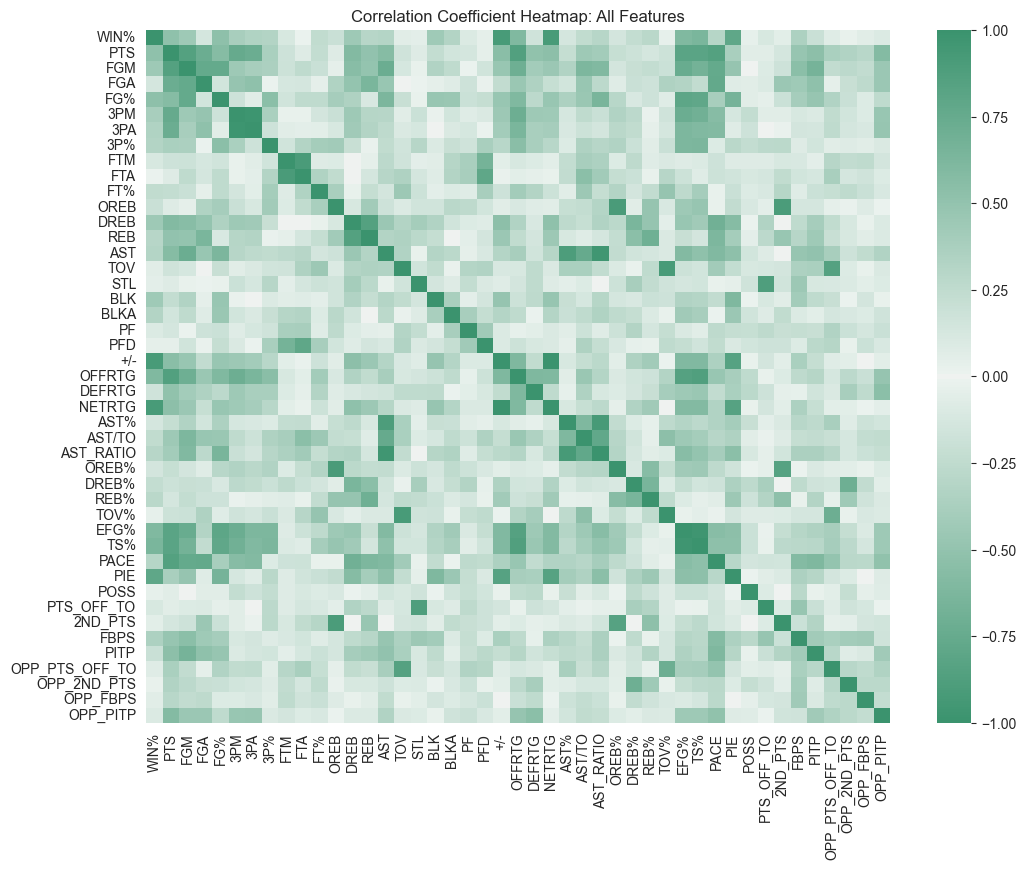

In [19]:
fig, ax = plt.subplots(figsize=(12, 9))
# Heatmap of the correlations.
sns.heatmap(corrs_all, ax=ax, cmap=CMAP, vmin=-1, vmax=1)
ax.set_title("Correlation Coefficient Heatmap: All Features")

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "correlation_heatmap_all_features.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()

#### Maximum and 80th Percentile Correlation Calculations

In [20]:
def get_percentile(corr_col: Series, percentile: float = 1.0) -> float:
    """Returns the percentile value for a given correlation coefficient Series.

    The default value for `percentile` will return the maximum value of the Series.

    Parameters
    ----------
    corr_col : Series
        Collection of correlation coefficients
    percentile : float, optional
        Percentile entered as a quantile (0.0 to 1.0 inclusive), by default 1.0

    Returns
    -------
    float
        Percentile value.
    """
    # The value at index 0 is removed since this is just the correlation of the stat
    # with itself.
    corr_col = corr_col.abs().sort_values(ascending=False)[1:]
    return corr_col.quantile(q=percentile)


# Apply `get_percentile` to each column in `corr` using the default value for the
# percentile parameter to return max correlation values.
max_corrs = corrs_all.agg(func=get_percentile)
percentile_corrs = corrs_all.agg(func=get_percentile, percentile=percentile)

#### Filter Max Correlations Using Threshold

In [21]:
# Max correlation filtering.
max_corrs = max_corrs[max_corrs < max_corr_threshold].sort_values(ascending=False)

print(
    f"Number of stats with max(r) < {max_corr_threshold}: {len(max_corrs)} out of {len(all_features)}\n"
)
print(f"Stats with max(r) < {max_corr_threshold}: {list(max_corrs.index)}")

Number of stats with max(r) < 0.8: 17 out of 45

Stats with max(r) < 0.8: ['PFD', 'AST/TO', 'FGA', 'DREB%', 'OPP_2ND_PTS', 'REB%', 'PITP', '3P%', 'BLK', 'DEFRTG', 'OPP_PITP', 'FBPS', 'FT%', 'BLKA', 'OPP_FBPS', 'PF', 'POSS']


#### Max Correlations Plot

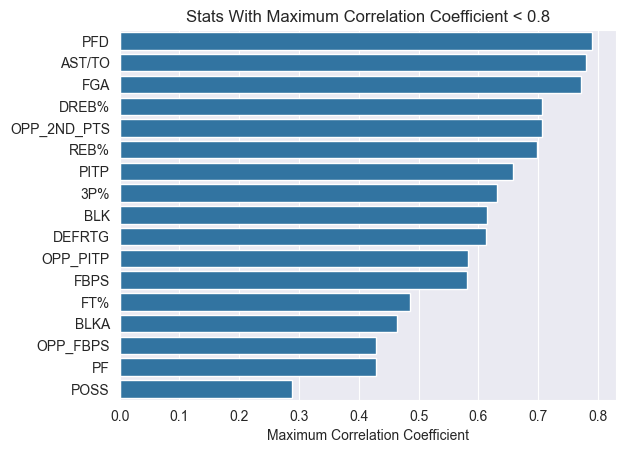

In [22]:
fig, ax = plt.subplots()
# Horizontal bar chart of max correlations.
sns.barplot(x=max_corrs, y=max_corrs.index, ax=ax, orient="h", color="tab:blue")
ax.set_title(f"Stats With Maximum Correlation Coefficient < {max_corr_threshold}")
ax.set_xlabel("Maximum Correlation Coefficient")
ax.set_ylabel("")

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "max_correlation_coefficients.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()

#### Filter Percentile Correlations Using Threshold

In [23]:
# Percentile correlation filtering.
percentile_corrs = percentile_corrs[
    percentile_corrs < percentile_corr_threshold
].sort_values(ascending=False)

print(
    f"Number of stats with {int(round_half_up(100*percentile))}th percentile r-value < {percentile_corr_threshold}: {len(percentile_corrs)} out of {len(all_features)}\n"
)
print(
    f"Stats with {int(round_half_up(100*percentile))}th percentile r-value < {percentile_corr_threshold}: {list(percentile_corrs.index)}\n"
)

Number of stats with 80th percentile r-value < 0.35: 18 out of 45

Stats with 80th percentile r-value < 0.35: ['TOV', 'BLK', 'FT%', 'DREB%', 'AST%', 'FTA', 'BLKA', 'OREB%', 'OPP_2ND_PTS', 'PF', 'PFD', 'TOV%', 'FTM', '2ND_PTS', 'OPP_FBPS', 'STL', 'POSS', 'PTS_OFF_TO']



#### Percentile Correlations Plot

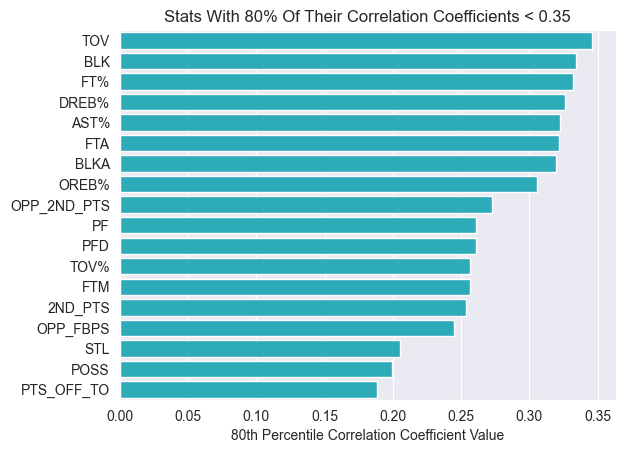

In [24]:
fig, ax = plt.subplots()
# Horizontal bar chart of 80th percentile correlations.
sns.barplot(
    x=percentile_corrs, y=percentile_corrs.index, ax=ax, orient="h", color="tab:cyan"
)
ax.set_title(
    f"Stats With {int(round_half_up(100*percentile))}% Of Their Correlation Coefficients < {percentile_corr_threshold}"
)
ax.set_xlabel(
    f"{int(round_half_up(100*percentile))}th Percentile Correlation Coefficient Value"
)
ax.set_ylabel("")

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "percentile_correlation_coefficients.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()

#### Principal Component Analysis (PCA) and Cumulative Explained Variance (CEV)

In [25]:
# Compute PCA using the scaled all feature stats ndarray.
pca_all = PCA(svd_solver="full").fit(X_train_scaled_all)
cev = np.cumsum(pca_all.explained_variance_ratio_)
component_range = range(1, len(cev) + 1)

#### Annotation Data

In [26]:
def create_annotation(cev: ndarray, target: float) -> tuple[int, float, str]:
    """Create annotation data for the nearest point to `target` on a CEV plot.

    Parameters
    ----------
    cev : ndarray
        Array of CEV values.
    target : float
        Target CEV ratio to find the nearest point to.

    Returns
    -------
    tuple(int, float, str)
        Number of components, associated CEV value, and annotation text.
    """
    index = np.argmin(np.abs(cev - target))
    cev_val = cev[index]
    # Due to zero indexing, shift index value by 1 for the component number.
    component = index + 1
    text = f"({component}, {cev_val:.2f})"

    return component, cev_val, text


# Create annotation data at 0.90 and 0.95 CEV.
component_90, cev_90, text_90 = create_annotation(cev, target=0.90)
component_95, cev_95, text_95 = create_annotation(cev, target=0.95)

#### CEV Plot

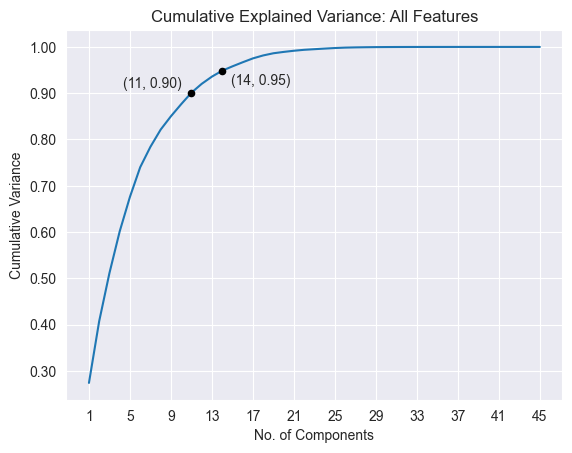

In [27]:
# Cumulative explained variance plot.
fig, ax = plt.subplots()
sns.lineplot(x=component_range, y=cev, ax=ax)
ax.scatter(
    [component_90, component_95], [cev_90, cev_95], s=20, color="black", zorder=3
)
ax.set_title("Cumulative Explained Variance: All Features")
ax.set_xlabel("No. of Components")
ax.set_ylabel("Cumulative Variance")
ax.set_xticks(component_range[::4])
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
ax.annotate(
    text_90,
    xy=(component_90, cev_90),
    xytext=(component_90 - 6.7, cev_90 + 0.01),
)
ax.annotate(
    text_95,
    xy=(component_95, cev_95),
    xytext=(component_95 + 0.9, cev_95 - 0.03),
)

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "cumulative_explained_variance_all_features.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()

### Analysis: Selected Features
#### Correlation Coefficient Matrix

In [28]:
# Normalize the data so that all features have the same scale.
scaler_selected = StandardScaler()
# `_selected` signifies this is X_train built from selected features only.
X_train_scaled = scaler_selected.fit_transform(X_train[selected_features])
# Convert `X_train_scaled` back into a DataFram in order to use the `corr` method
X_train_scaled = pd.DataFrame(X_train_scaled, columns=selected_features)
# Calculate the correlation matrix for all features.
corrs_selected = X_train_scaled.corr()

#### Heatmap

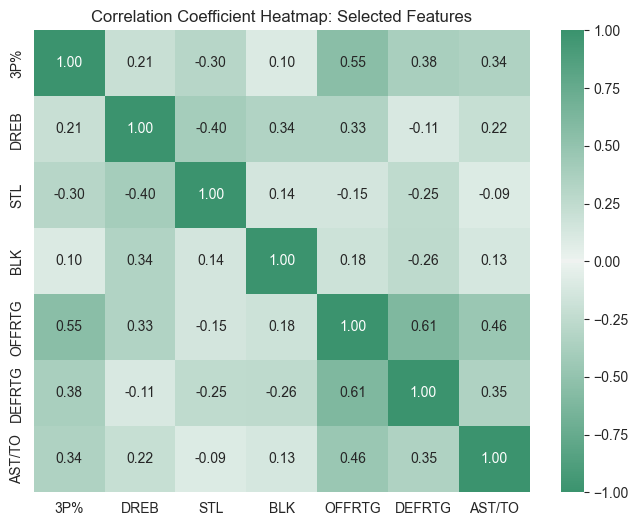

In [29]:
# Plot a heatmap of the correlations
fig, ax = plt.subplots(figsize=(8, 6))
# Heatmap of the correlations.
sns.heatmap(corrs_selected, ax=ax, cmap=CMAP, vmin=-1, vmax=1, annot=True, fmt=".2f")
ax.set_title("Correlation Coefficient Heatmap: Selected Features")

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "correlation_heatmap_selected_features.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()

#### PCA and CEV

In [30]:
# Compute PCA using the scaled selected feature stats ndarray.
pca_selected = PCA(svd_solver="full").fit(X_train_scaled)
cev = np.cumsum(pca_selected.explained_variance_ratio_)
component_range = range(1, len(cev) + 1)

#### CEV Plot

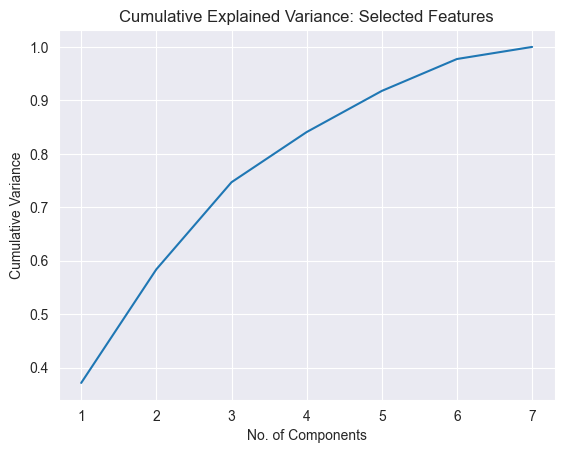

In [31]:
# Cumulative explained variance plot.
fig, ax = plt.subplots()
sns.lineplot(x=component_range, y=cev, ax=ax)
ax.set_title("Cumulative Explained Variance: Selected Features")
ax.set_xlabel("No. of Components")
ax.set_ylabel("Cumulative Variance")
ax.set_xticks(component_range)

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "cumulative_explained_variance_selected_features.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()

<br>
<hr>
<br>

## Machine Learning
### Outline
1. Scale `X_test` and `target`. No fit is performed here, only a transform based on the `scaler_selected` fit generated by `X_train` in order to prevent data leakage (influence of the test set on the any of the model fitting steps).
1. Create a model with `LogisticRegression()`.
1. Train the model with `classifier.fit()`.
1. Make predictions with `classifier.predict()`.
1. Validate the model with `accuracy_score()`.

#### Scale `X_test` and `target` and Convert to DataFrames

In [32]:
# Scale `X_test` using `scaler_selected`.
X_test_scaled = scaler_selected.transform(X_test[selected_features])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=selected_features)

# Scale target data `current_stats` prior to prediction using `scaler_selected`.
target_scaled = scaler_selected.transform(current_stats[selected_features])
target_scaled = pd.DataFrame(target_scaled, columns=selected_features)

### Train the Model

In [33]:
# Create a `LogisticRegression` model instance.
classifier = LogisticRegression(solver="liblinear", max_iter=2000, random_state=1)

# Fit the model with the training data.
classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2000, random_state=1, solver='liblinear')

### Test and Validate the Model
#### Predict Using Test Data and Accuracy Check

In [34]:
# Predict using the test set.
y_test_predict = classifier.predict(X_test_scaled)

# Accuracy score.
score = accuracy_score(y_test, y_test_predict)
print(f"Accuracy: {score:.2f}")

# Test set prediction results as a DataFrame. Keep in mind that the test train split was
# stratified.
test_results = pd.DataFrame({"Actual": y_test, "Predicted": y_test_predict})
test_results

Accuracy: 0.96


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,1,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


#### Confusion Matrix

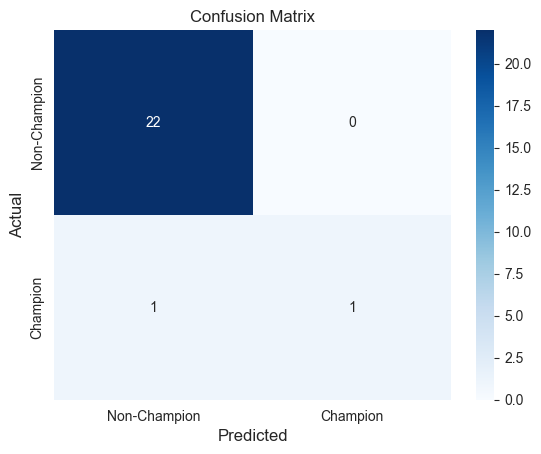

In [35]:
# Generate the confusion matrix.
confusion = confusion_matrix(y_test, y_test_predict)

# Confusion matrix plot.
fig, ax = plt.subplots()
sns.heatmap(
    confusion,
    ax=ax,
    xticklabels=["Non-Champion", "Champion"],
    yticklabels=["Non-Champion", "Champion"],
    annot=True,
    cmap="Blues",
)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "confusion_matrix.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()

### Predict the Champion
#### Predicted Labels

In [36]:
# Predict the champion team.
current_prediction = classifier.predict(target_scaled)

# Print out the name of the champion.
champions = current_stats.iloc[current_prediction.nonzero()]["TEAM"]
champion_str = ", ".join(list(champions))
print(f"Predicted Champion: {champion_str}")

Predicted Champion: Memphis Grizzlies


#### Probability Estimates

In [37]:
# Calculate the probabilities for each class ("not-champion" and "champion") for each
# team.
current_probabilities = classifier.predict_proba(target_scaled)

# Create DataFrame collecting all of the probabilities.
predicted_champion = pd.DataFrame(
    {
        "Team": current_stats["TEAM"],
        "Not-Champion": current_probabilities[:, 0],
        "Champion": current_probabilities[:, 1],
    }
)
predicted_champion = predicted_champion.sort_values(
    by="Champion", ascending=False
).round(2)
# Save as csv for use in the website.
predicted_champion.to_csv(
    path_or_buf=DATA_DIR / "probability_estimates.csv", index=False
)
predicted_champion

,Team,Not-Champion,Champion
1,Memphis Grizzlies,0.42,0.58
12,Minnesota Timberwolves,0.79,0.21
0,Phoenix Suns,0.86,0.14
2,Golden State Warriors,0.88,0.12
5,Boston Celtics,0.89,0.11
7,Philadelphia 76ers,0.90,0.10
13,Brooklyn Nets,0.91,0.09
8,Utah Jazz,0.92,0.08
10,Toronto Raptors,0.92,0.08
6,Milwaukee Bucks,0.93,0.07


### Feature Importance
#### Coefficients and Relative Importance

In [38]:
# Calculate relative feature importance (relative to the maximum coefficient).
rel_importance = classifier.coef_ / classifier.coef_.max()

# Create relative feature importance DataFrame.
feature_importance = (
    pd.DataFrame(
        rel_importance[0], index=selected_features, columns=["Relative Importance"]
    )
    .sort_values(by="Relative Importance", ascending=False)
    .round(2)
)
# Save as csv for use in the website.
feature_importance.to_csv(path_or_buf=DATA_DIR / "feature_importance.csv")
feature_importance

,Relative Importance
STL,1.00
BLK,0.93
OFFRTG,0.55
DREB,0.48
3P%,0.43
DEFRTG,0.18
AST/TO,0.13


#### Relative Feature Importance Plot

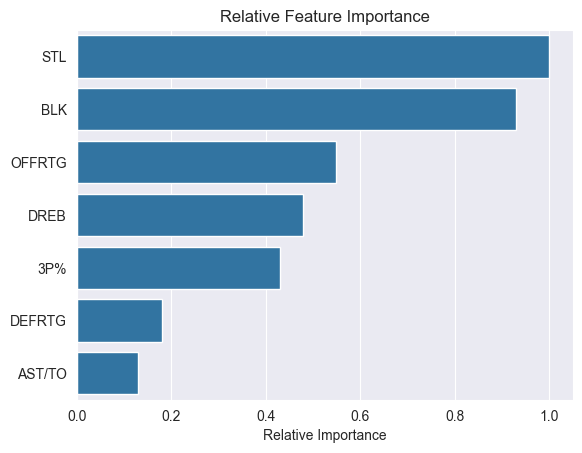

In [39]:
# Relative feature importance plot.
fig, ax = plt.subplots()
sns.barplot(
    x=feature_importance["Relative Importance"],
    y=feature_importance.index,
    ax=ax,
    orient="h",
)
ax.set_title("Relative Feature Importance")
ax.set_xlabel("Relative Importance")
ax.set_ylabel("")

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "feature_importance.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()